# DQN ([Nature](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)) with maybe additional extensions

Included with the gym environment, a frameskip of 4 is applied meaning the agent only sees every 4th frame and each action selected is repeated 4 times.<BR>
By default, Breakout is not fully Markovian because the agent cannot determine the motion of the ball based off a single frame.<BR>
We can effectively restore the Markov property by stacking the last 4 observed frames $(t_0, t_4, t_8, t_{12})$.<BR>

Vanilla DQN uses two Q-networks with hard syncing of networks every ~$10,000$ environment steps.

Vanilla DQN update rule:
$$\text{update target } y = r_{t+1} + \gamma \cdot \max_{a'} Q_\text{target}(s', a') \cdot (1 - \text{terminated})$$

If the episode was terminated this state, $(1 - \text{terminated})$ is $0$ and so the equation reduces to $y = r_{t+1}$ as the agent does not recieve rewards after the terminal state.

### Implementation Details

* To save memory, states are stored as in replay buffer as type uint8 then normalized by division with $255$ to fall within $[0,1]$ only once inside the forward pass in QNetwork.
* Tensorboard was used for telemetry. For every training episode, I tracked the return, number of steps performed, as well as the current epsilon. At each learning update, I tracked the MSE loss, max single gradient, and total gradient norm.

### Differences from Nature

* Instead of RMSProp, I used Adam optimizer with the same learning rate of 0.00025.
* Instead of maxpooling over last two frames (e.g. preprocessed frame at $t_4$ would be the maxpooling of $t_4, t_3$), I did simple downsampling and let the gym environment handle frameskipping. This could be a problem - not doing maxpooling might mean the conv layers with large strides can't pick up the thinner outline of the ball. However since there is no flickering in this environment it's not too concerning.
* I padded the width of the input frame in preprocessing to conform to a shape of (84, 84).
* Even using uint8, a replay buffer of capacity 1e6 requires 56 GB of memory which is too much so I used a buffer of capacity 100k instead.

### Training

* I started off with a small test run locally then moved training to Kaggle's P100 GPU, which provided >10x performance. After training for ~14.5 million steps (12 hours), I rendered the environment and let the model play with a greedy policy. It did not seem to learn any behavior at all. It would always move to the far left of the screen and stay there. Inspecting the conv layer outputs, I noticed that the 2nd and 3rd conv layer's activations were entirely all zeros. Attributing this to the dying ReLU problem, I switched all ReLU activations to leaky ReLU and reset epsilon to 1.0, linearly annealing it to 0.1 over the next 1 millon steps. The difference was stark and the model started quickly improving almost immediately after.

* At ~19.3 million steps, I noticed a bit of training instability. I extended the size of the replay buffer to 400k samples as P100 has sufficient memory. In addition, the sync frequency was increased from 10000 steps to 40000 steps. Epsilon was kept at 0.1.

* After 30 million steps, this setup did not end up converging. The agent did not fully learn to release the ball, relying on no-op actions at the start and epsilon-greedy exploration to release the ball. I restored from a training checkpoint at ~20 million steps, removing no-op start and reset epsilon to 1.0,  annealing it 0.01 instead of 0.1 over 1 million steps. I also added gradient clipping where the total gradient norm was scaled down to 5.0 when it was over 5.0.

### Possible Extensions

* Potential to add DDQN update rule to prevent overestimation bias because of $\max$-ing over Q-values:
$$\text{update target } y = r_{t+1} + \gamma \cdot Q_\text{target}(s', a^*) \cdot (1 - \text{terminated})$$ 
where
$$a^* = \arg\max_{a'} Q_\text{online}(s', a')$$

Although maybe DDQN is not needed as it requires two forward passes to calculate $y$.<br> 
And if we apply reward clipping to $[-1, 1]$ like in Nature, overestimation shouldn't be too much of a problem.<BR>
And if we trust the Rainbow DQN paper, no double performs about the same as with double.<BR>

    "Comparing Rainbow to the agent where double Q-learning was ablated, we observed that the actual returns are often higher than 10 and therefore fall outside the support of the distribution, spanning from −10 to +10. This leads to underestimated returns, rather than overestimations. We hypothesize that clipping the values to this constrained range counteracts the overestimation bias of Q-learning. Note, however, that the importance of double Q-learning may increase if the support of the distributions is expanded."

* Other components from Rainbow DQN could be useful for faster convergence:
  + Prioritized DDQN,
  + Dueling DDQN,
  + A3C,
  + Distributional DQN,
  + Noisy DQN.

<BR>

* Potential to add soft syncing allowing the target network to be updated at every learning step:
$$\theta' \leftarrow \tau \theta + (1-\tau) \theta'$$
where $\theta'$ are target network parameters, $\theta$ are online network parameters, and $\tau \approx 0.001$ is a hyperparameter denoting how much blend we want.

Empirically, I found that soft updates worked well on classic control environments.<BR>
Athough Rainbow DQN doesn't even have soft updates so it's probably not important, or maybe even counterproductive. 

In [1]:
from gymnasium.wrappers import FrameStackObservation
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
from pathlib import Path
import gymnasium as gym
from tqdm import tqdm
from PIL import Image
import numpy as np
import random
import ale_py
import time
import cv2
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from utils import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cpu


In [3]:
def remake_env(render_mode=None):
    global env
    if 'env' in globals(): 
        env.close()
        del env
    env = gym.make('BreakoutDeterministic-v4', render_mode=render_mode)
    env = FrameStackObservation(env, 4)  # stack previous 4 frames to simulate motion and mend Markov property

In [13]:
remake_env('human')  # test env
state, info = env.reset()
for step in range(200):
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    clear_output(wait=True)
    print('taking action', action, ' got reward', reward)
    if done or truncated:
        print(f"Episode finished with environment reward: {reward}")
        break

taking action 2  got reward 0.0


In [5]:
env.spec.kwargs.get("frameskip", "No frameskip found")

4

In [15]:
remake_env(None)
env.close()

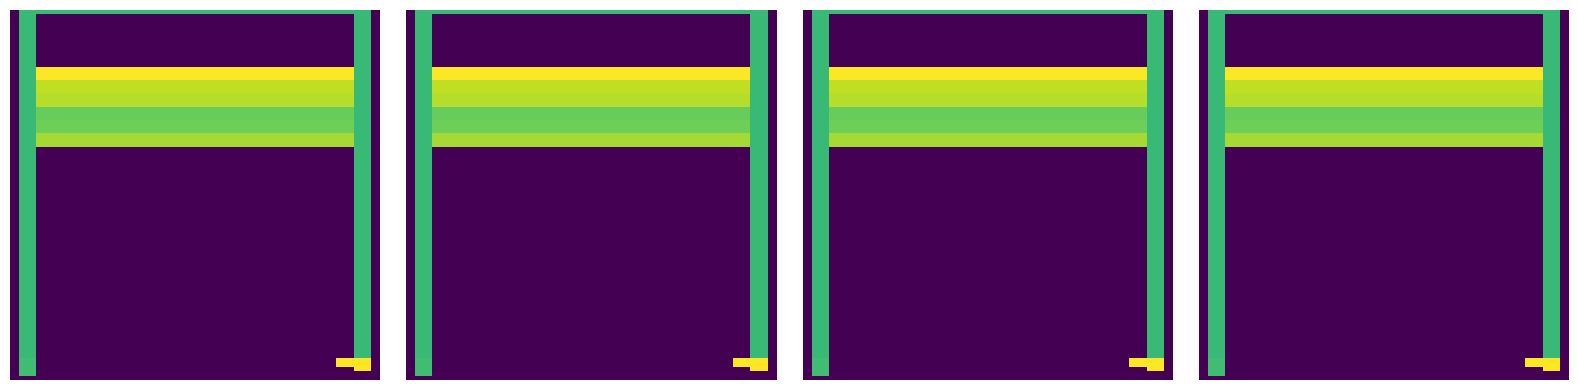

In [7]:
x = preprocess_state(state)
show_batch(x)  # what the agent sees every time it chooses an action - 4-frame stack of grayscale 84x84 values

In [8]:
online_net = QNetwork()

(32, 20, 20) 
 (20, 20)


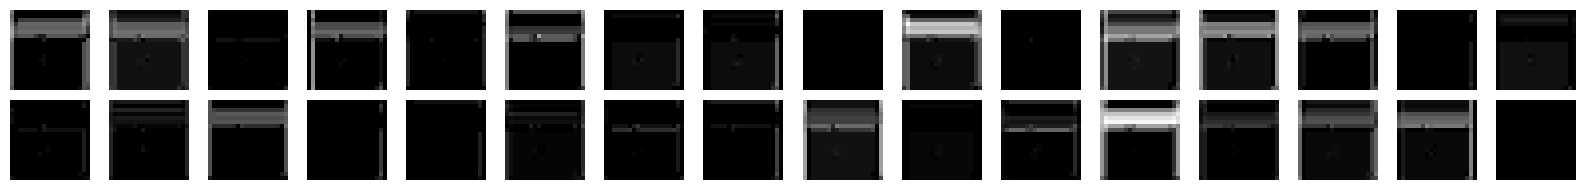

In [27]:
# what the network sees after 1st conv layer and relu (32 filters with 8x8 kernel, stride of 4)
# each resulting box is a 20x20 image
with torch.no_grad():
    x = preprocess_state(state)
    x = x / 255.0
    x = online_net.conv1(x)
    x = F.leaky_relu(x)
    x = np.array(x).squeeze(0)
    x = (x - x.min()) / (x.max() - x.min()) * 255.0  # min-max scaling for clarity
print(x.shape, '\n', x[0].shape)
fig, axes = plt.subplots(2, 16, figsize=(16, 2))
for i in range(32):
    axes[i // 16, i % 16].imshow(Image.fromarray(x[i]))
    axes[i // 16, i % 16].axis('off')
plt.tight_layout(), plt.show();

(64, 9, 9) 
 (9, 9)


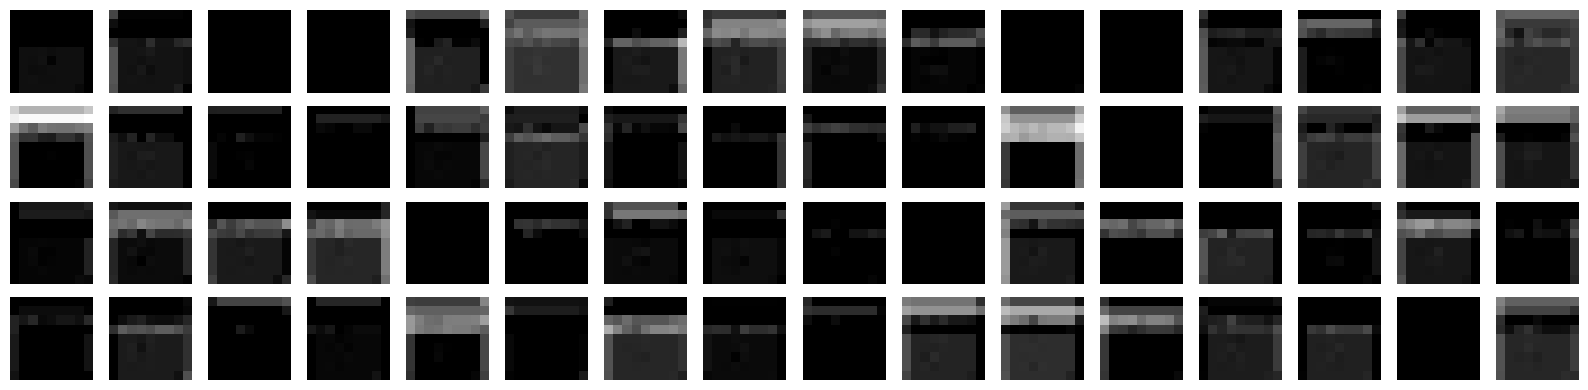

In [26]:
# what the network sees after 2nd conv layer and relu (64 filters with 4x4 kernel, stride of 2)
# each resulting box is a 9x9 image
with torch.no_grad():
    x = preprocess_state(state)
    x = x / 255.0
    x = online_net.conv1(x)
    x = F.leaky_relu(x)
    x = online_net.conv2(x)
    x = F.leaky_relu(x)
    x = np.array(x).squeeze(0)
    x = (x - x.min()) / (x.max() - x.min() + 1e-7) * 255.0  # min-max scaling for clarity
print(x.shape, '\n', x[0].shape)
fig, axes = plt.subplots(4, 16, figsize=(16, 4))
for i in range(64):
    axes[i // 16, i % 16].imshow(Image.fromarray(x[i]))
    axes[i // 16, i % 16].axis('off')
plt.tight_layout(), plt.show();

(64, 7, 7) 
 (7, 7)


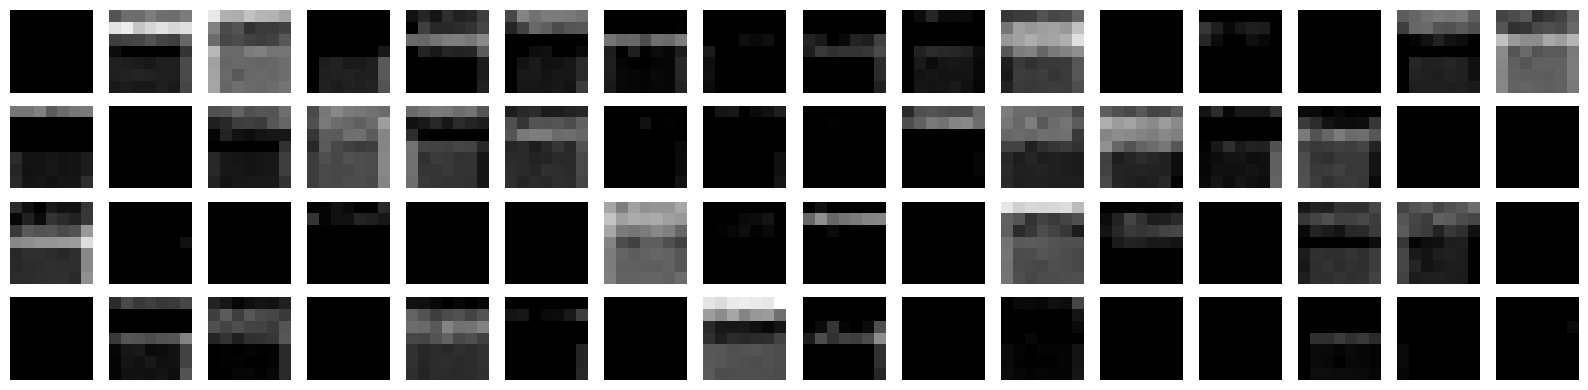

In [24]:
# what the network sees after 3rd conv layer and relu (64 filters with 3x3 kernel, stride of 1)
# each resulting box is a 7x7 image
with torch.no_grad():
    x = preprocess_state(state)
    x = x / 255.0
    x = online_net.conv1(x)
    x = F.leaky_relu(x)
    x = online_net.conv2(x)
    x = F.leaky_relu(x)
    x = online_net.conv3(x)
    x = F.leaky_relu(x)
    x = np.array(x).squeeze(0)
    x = (x - x.min()) / (x.max() - x.min() + 1e-7) * 255.0  # min-max scaling for clarity
print(x.shape, '\n', x[0].shape)
fig, axes = plt.subplots(4, 16, figsize=(16, 4))
for i in range(64):
    axes[i // 16, i % 16].imshow(Image.fromarray(x[i]))
    axes[i // 16, i % 16].axis('off')
plt.tight_layout(), plt.show();